In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

2024-08-05 13:46:51.979340: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 13:46:52.009066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 13:46:52.009094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 13:46:52.010513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 13:46:52.015719: I tensorflow/core/platform/cpu_feature_gua

In [2]:
ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [3]:
df['Speed Difference (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df['Wind Speed (TAO)']

df['Wind Direction (TAO)'] = (-(df['Wind Direction (TAO)'] - 90.0) + 360)%360
df['Wind Direction (QuikSCAT)'] = (-(df['Wind Direction (QuikSCAT)'] - 90.0) + 360)%360
df['mean WDIR 30min'] = (-(df['mean WDIR 30min'] - 90.0) + 360)%360
df['mean WDIR 60min'] = (-(df['mean WDIR 60min'] - 90.0) + 360)%360
df['mean WDIR 120min'] = (-(df['mean WDIR 120min'] - 90.0) + 360)%360

df['Direction Difference (QuikSCAT - TAO)'] = ((df['Wind Direction (QuikSCAT)'] - df['Wind Direction (TAO)'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 30 min mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 30min']
df['Direction Difference (QuikSCAT - TAO 30 min mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 30min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 30 min mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 30 min mean)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 1 hr mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 60min']
df['Direction Difference (QuikSCAT - TAO 1 hr mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 60min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 1 hr mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 1 hr mean)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 2 hr mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 120min']
df['Direction Difference (QuikSCAT - TAO 2 hr mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 120min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 2 hr mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 2 hr mean)'] = dirDiff


df['Zonal Neutral Wind Speed at 10m (TAO)'] = df['Neutral Wind Speed at 10m (TAO)']*np.cos(np.deg2rad(df['Wind Direction (TAO)']))
df['Meridional Neutral Wind Speed at 10m (TAO)'] = df['Neutral Wind Speed at 10m (TAO)']*np.sin(np.deg2rad(df['Wind Direction (TAO)']))

df['Zonal Neutral Wind Speed at 10m (QuikSCAT)'] = df['Wind Speed (QuikSCAT)']*np.cos(np.deg2rad(df['Wind Direction (QuikSCAT)']))
df['Meridional Neutral Wind Speed at 10m (QuikSCAT)'] = df['Wind Speed (QuikSCAT)']*np.sin(np.deg2rad(df['Wind Direction (QuikSCAT)']))

df['Zonal Wind Speed Difference (QuikSCAT - TAO)'] = df['Zonal Neutral Wind Speed at 10m (QuikSCAT)'] - df['Zonal Neutral Wind Speed at 10m (TAO)']
df['Meridional Wind Speed Difference (QuikSCAT - TAO)'] = df['Meridional Neutral Wind Speed at 10m (QuikSCAT)'] - df['Meridional Neutral Wind Speed at 10m (TAO)']


In [7]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
           'Direction Difference (QuikSCAT - TAO)']
X = df[selectX]
normX = (X - X.mean(axis=0))/ X.std(axis=0)

# Function to compute silhouette score for one sample
def silhouette_score_sample(i, X, labels, metric='euclidean'):
    mask = np.ones(len(X), dtype=bool)
    mask[i] = False
    current_label = labels[i]
    
    # Calculate a(i)
    a_i = np.mean(pairwise_distances([X[i]], X[labels == current_label], metric=metric)[0])
    
    # Calculate b(i)
    b_i = np.inf
    for label in np.unique(labels):
        if label == current_label:
            continue
        b_i = min(b_i, np.mean(pairwise_distances([X[i]], X[labels == label], metric=metric)[0]))
    
    return (b_i - a_i) / max(a_i, b_i)
    
def getScore(n_cluster, X):
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init='auto').fit(X)
    labels = kmeans.labels_
    
    # Calculate silhouette scores in parallel
    n_jobs = -1  # Use all available cores
    silhouette_scores = Parallel(n_jobs=n_jobs)(
        delayed(silhouette_score_sample)(i, X, labels) for i in range(len(X))
    )  
    # Calculate the average silhouette score
    average_silhouette_score = np.mean(silhouette_scores)

    return average_silhouette_score


In [8]:
range_n_clusters = np.arange(2,10)
silhouette_scores = []
for n_cluster in range_n_clusters:
    print(f'cluster : {n_cluster}')
    silhouette_scores.append(getScore(n_cluster, normX.to_numpy()))

silhouette_scores = np.array(silhouette_scores)
index = np.argmax(silhouette_scores)
best_n_clusters = range_n_clusters[index]
best_score = silhouette_scores[index]

cluster : 2
cluster : 3
cluster : 4
cluster : 5
cluster : 6
cluster : 7
cluster : 8
cluster : 9


The optimal number of clusters is: 3 with a silhouette score of 0.5640151204432663


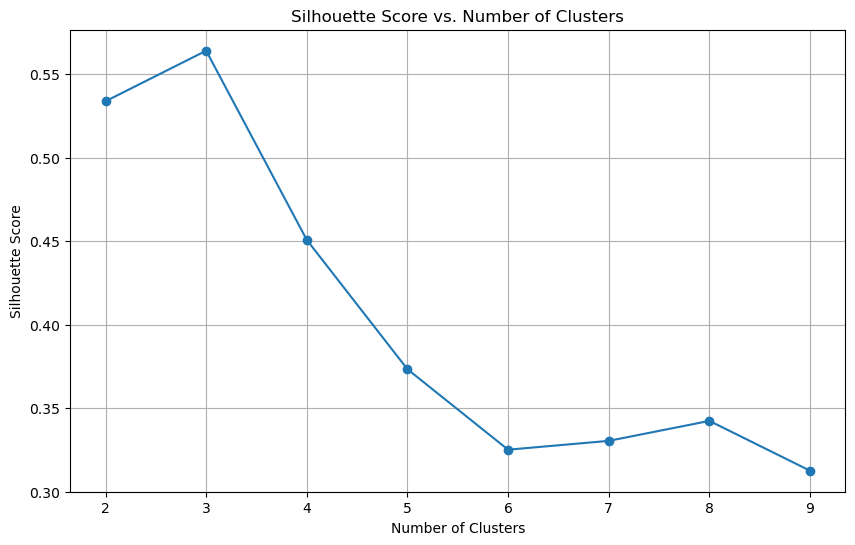

In [9]:
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
#plt.show()

print(f'The optimal number of clusters is: {best_n_clusters} with a silhouette score of {best_score}')